## Estrella

In [1]:
import numpy as np
import matplotlib.patches as patches
from matplotlib.path import Path
import matplotlib.pyplot as plt

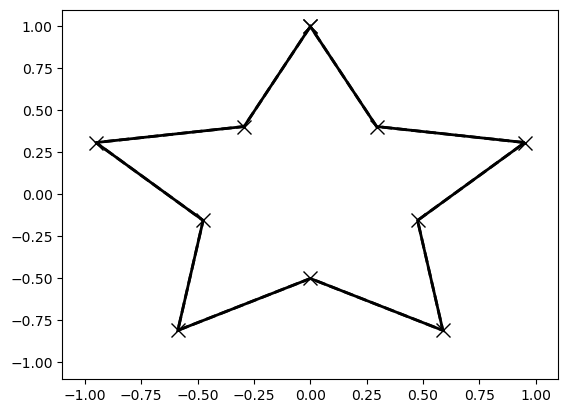

In [4]:
path = Path.unit_regular_star( 5, innerCircle=0.5)

fig, ax = plt.subplots()
patch = patches.PathPatch(path, facecolor='none', lw=2)
ax.add_patch(patch)

xs, ys = zip(*path.vertices)
ax.plot(xs, ys, 'x--', lw=2, color='black', ms=10)

ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
plt.show()

In [5]:
N = int( 10000 / (len(path.vertices) - 1) )
puntos = []
normales = []
for i in range( len(path.vertices) - 1 ):
    directions = np.tile(path.vertices[i+1] - path.vertices[i], (N,1))
    puntos.append( 
        np.tile( path.vertices[i], (N,1) ) + np.linspace(0,1,N)[..., None] * directions
    )

    normales.append(
        np.concatenate( [ directions[:, 1][...,None],(-1 * directions[:,0])[...,None] ], axis=1 )
    )

In [6]:
puntos = np.concatenate( puntos ) * 0.75
normales  = np.concatenate( normales )

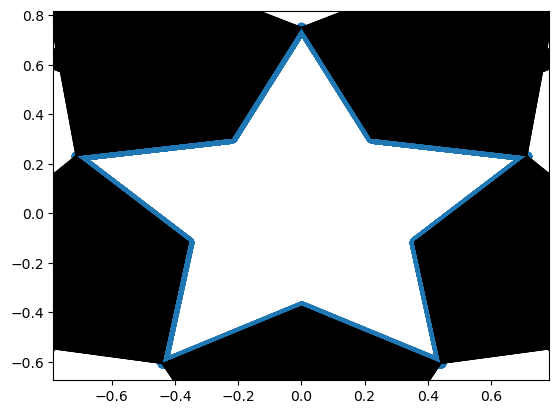

In [7]:
plt.scatter( puntos[:,0], puntos[:,1] )

U = normales[:, 0]# - puntos[:, 0]  # Vector components along x-axis
V = normales[:, 1]# - puntos[:, 1]  # Vector components along y-axis

# Create the quiver plot
plt.quiver(puntos[:,0], puntos[:,1], U, V, angles='xy', scale_units='xy', scale=1)

In [8]:
np.savez( 'data/star/star_pc.npz',points=puntos, normals=normales )

In [9]:
np.load( 'data/star/star_pc.npz')['points'].shape

(10000, 2)

## Circulo

In [2]:
import numpy as np
import matplotlib.pyplot as plt

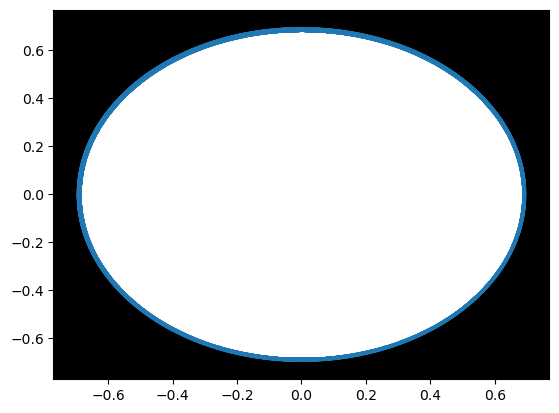

In [9]:
N = 5000
r = 0.7
theta = np.linspace(0, 2 * np.pi, N)

points = np.concatenate( [ np.sin(theta)[...,None] * r, np.cos(theta)[...,None] * r ], axis=1 )
normals = np.concatenate( [ np.sin(theta)[...,None] , np.cos(theta)[...,None] ], axis=1 )

plt.scatter( points[:,0], points[:,1] )
plt.quiver(points[:,0], points[:,1], normals[:,0], normals[:,1], angles='xy', scale_units='xy', scale=1)

In [10]:
np.savez( 'data/circle/point_cloud.npz', points=points, normals=normals )

## El chat

/tmp/ipykernel_2716784/738654262.py:8: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return (np.math.factorial(n) /
/tmp/ipykernel_2716784/738654262.py:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.factorial(i) * np.math.factorial(n - i))) * (t ** i) * ((1 - t) ** (n - i))


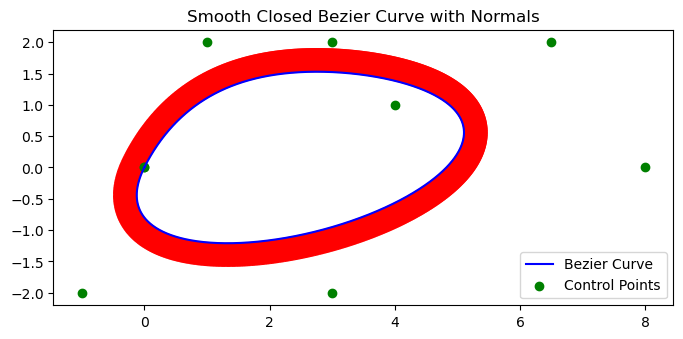

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from scipy.spatial import Voronoi, Delaunay, voronoi_plot_2d

# Function to compute Bernstein polynomials
def bernstein_poly(i, n, t):
    return (np.math.factorial(n) / 
            (np.math.factorial(i) * np.math.factorial(n - i))) * (t ** i) * ((1 - t) ** (n - i))

# Bezier curve function
def bezier_curve(control_points, n_points=100):
    n = len(control_points) - 1
    t = np.linspace(0.0, 1.0, n_points)
    curve = np.zeros((n_points, 2))
    for i in range(n + 1):
        curve += np.outer(bernstein_poly(i, n, t), control_points[i])
    return curve

# Tangent vector computation
def compute_tangents(control_points, n_points=100):
    n = len(control_points) - 1
    t = np.linspace(0.0, 1.0, n_points)
    tangents = np.zeros((n_points, 2))
    for i in range(n):
        tangents += np.outer((n * bernstein_poly(i, n - 1, t)), (control_points[i + 1] - control_points[i]))
    return tangents

# Normal vector computation (orthogonal to tangent)
def compute_normals(tangents):
    normals = np.zeros_like(tangents)
    normals[:, 0] = -tangents[:, 1]
    normals[:, 1] = tangents[:, 0]
    # Normalize normals
    norm = np.linalg.norm(normals, axis=1)
    normals = normals / norm[:, np.newaxis]
    return normals

# Define control points for a smooth closed loop Bezier curve
control_points = np.array([
    [0.0, 0.0],
    [1.0, 2.0],
    [3.0, 2.0],
    [4.0, 1.0],
    [6.5, 2.0],
    [8.0, 0.0],
    [3.0, -2.0],
    [1.0, -2.0],
])

# Create symmetry for smooth closure
# Ensure the first and last control points are symmetric around the start/end point
control_points = np.vstack([control_points, [0.0, 0.0]])  # Close the loop

# Adjust second and second-last points for smoothness (C1 continuity)
control_points[-2] = 2 * control_points[-1] - control_points[1]  # Make the last control point mirror the first

# Generate the Bezier curve
n_points = 10000
curve = bezier_curve(control_points, n_points)

# Compute tangents and normals
tangents = compute_tangents(control_points, n_points)
normals = compute_normals(tangents)

# Plotting the curve and normals
plt.figure(figsize=(8, 8))
plt.plot(curve[:, 0], curve[:, 1], label='Bezier Curve', color='blue')

# Sample and plot normals at every 10th point
for i in range(0, n_points, 10):
    plt.arrow(curve[i, 0], curve[i, 1], normals[i, 0] * 0.3, normals[i, 1] * 0.3, color='red', head_width=0.05)

plt.scatter(control_points[:, 0], control_points[:, 1], color='green', label='Control Points')
plt.legend()
plt.title('Smooth Closed Bezier Curve with Normals')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [17]:
np.min( curve, axis=0), np.max(curve,axis=0)

curve -= np.min(curve,axis=0)
curve /= np.max( curve, axis=0) / 2
curve -= np.ones((1,2))
curve *= 0.75

np.min( curve, axis=0), np.max(curve,axis=0)

(array([-0.75, -0.75]), array([0.75, 0.75]))

In [18]:
def compute_triangle_circumcenters(xy_pts, tri_arr):
    """
    Compute the centers of the circumscribing circle of each triangle in a triangulation.
    :param np.array xy_pts : points array of shape (n, 2)
    :param np.array tri_arr : triangles array of shape (m, 3), each row is a triple of indices in the xy_pts array

    :return: circumcenter points array of shape (m, 2)
    """
    tri_pts = xy_pts[tri_arr]  # (m, 3, 2) - triangles as points (not indices)

    # finding the circumcenter (x, y) of a triangle defined by three points:
    # (x-x0)**2 + (y-y0)**2 = (x-x1)**2 + (y-y1)**2
    # (x-x0)**2 + (y-y0)**2 = (x-x2)**2 + (y-y2)**2
    #
    # becomes two linear equations (squares are canceled):
    # 2(x1-x0)*x + 2(y1-y0)*y = (x1**2 + y1**2) - (x0**2 + y0**2)
    # 2(x2-x0)*x + 2(y2-y0)*y = (x2**2 + y2**2) - (x0**2 + y0**2)
    a = 2 * (tri_pts[:, 1, 0] - tri_pts[:, 0, 0])
    b = 2 * (tri_pts[:, 1, 1] - tri_pts[:, 0, 1])
    c = 2 * (tri_pts[:, 2, 0] - tri_pts[:, 0, 0])
    d = 2 * (tri_pts[:, 2, 1] - tri_pts[:, 0, 1])

    v1 = (tri_pts[:, 1, 0] ** 2 + tri_pts[:, 1, 1] ** 2) - (tri_pts[:, 0, 0] ** 2 + tri_pts[:, 0, 1] ** 2)
    v2 = (tri_pts[:, 2, 0] ** 2 + tri_pts[:, 2, 1] ** 2) - (tri_pts[:, 0, 0] ** 2 + tri_pts[:, 0, 1] ** 2)

    # solve 2x2 system (see https://en.wikipedia.org/wiki/Invertible_matrix#Inversion_of_2_%C3%97_2_matrices)
    det = (a * d - b * c)
    detx = (v1 * d - v2 * b)
    dety = (a * v2 - c * v1)

    x = detx / det
    y = dety / det

    return (np.vstack((x, y))).T

def compute_voronoi_vertices_and_edges_2d(points, r_thresh=np.inf):
    """
    Compute (finite) Voronoi edges and vertices of a set of points.
    :param points: input points.
    :param r_thresh: radius value for filtering out vertices corresponding to
    Delaunay triangles with large radii of circumscribing circle (alpha-shape condition).
    :return: array of xy Voronoi vertex points and an edge list.
    """
    dt = Delaunay(points)
    xy_centers = compute_triangle_circumcenters(dt.points, dt.simplices)  # uses function from stackoverflow.com/a/65105672/9702190

    # filtering triangles that have radius > thresh
    simp_pts_0 = dt.points[dt.simplices[:, 0]]
    radii = np.linalg.norm(xy_centers - simp_pts_0, axis=1)
    is_in = radii < r_thresh

    # build an edge list from (filtered) triangle neighbor relations
    edge_lst = []
    for i in range(len(dt.neighbors)):
        if not is_in[i]:
            continue  # i is an outside triangle (large radius)
        for j in dt.neighbors[i]:
            if j != -1 and is_in[j]:
                edge_lst.append((i, j))

    return xy_centers, edge_lst

c, e = compute_voronoi_vertices_and_edges_2d( curve )

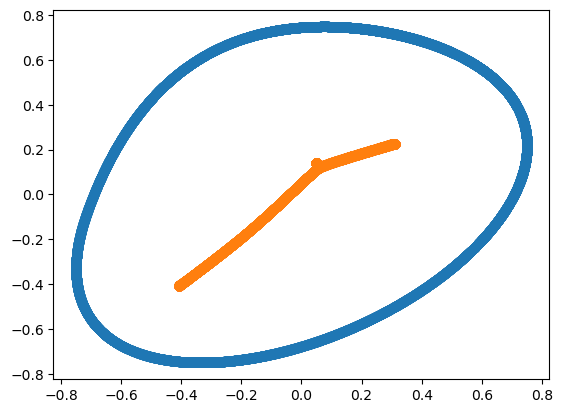

In [19]:
plt.scatter( curve[:,0],curve[:,1])
plt.scatter( c[:,0], c[:,1])

In [20]:
np.savez( 'data/bezier/bezier_pc.npz',points=curve, normals=normals / np.linalg.norm(normals, axis=1) [...,None], medial_axis=c )